In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import xarray as xr

import scipy.stats as stats

In [3]:
def read_in_AOD_SW(path):
    station_locDF = pd.DataFrame()

    # latlon = [[i.split('/')[-1][:6],i.split('/')[-1][7:-4]] for i in glob.glob(f'{path}/*.npy')]
    latlon = [[i.split('/')[-1].split('-')[0],i.split('/')[-1].split('-')[1][:-4]] if len(i.split('/')[-1].split('-')) == 2 else [i.split('/')[-1].split('-')[0],'-'+i.split('/')[-1].split('-')[-1][:-4]] for i in glob.glob(f'{path}*.npy')]

    station_locDF = pd.DataFrame()
    station_locDF['id'] = np.arange(len(latlon))

    station_locDF['lat'] = np.nan
    station_locDF['lon'] = np.nan

    station_locDF['AOD-SW'] = np.nan
    station_locDF['plus'] = np.nan
    station_locDF['minus'] = np.nan

    for i in range(len(latlon)):
        k = np.where(station_locDF.id == i)[0][0]
        station_locDF.loc[k,'lat'] = float(latlon[i][0])
        station_locDF.loc[k,'lon'] = float(latlon[i][1])

        result = np.load(path+'/'+str(latlon[i][0])+'-'+str(latlon[i][1])+'.npy', allow_pickle = True)

        if (0 not in result[-1][1:]) and all(~np.isnan(result[-1][1:])) and np.unique(np.sign(result[-1][1:])).shape[0] == 1:
            station_locDF.loc[k, 'AOD-SW'] = result[-1][0]
            station_locDF.loc[k, 'minus'] = result[-1][0] - result[-1][1]
            station_locDF.loc[k, 'plus'] = result[-1][2] - result[-1][0]

    return station_locDF


def ERF(ce, aod, ceplus, ceminus, aodplus = None, aodminus = None, model = False):
    erf = 0.2 * ce * aod
    if model:
        errplus = abs(erf)*0.2*np.sqrt((ceplus/ce)**2)
        errminus = abs(erf)*0.2*np.sqrt((ceminus/ce)**2)
    else:
        errplus = abs(erf)*0.2*np.sqrt((ceplus/ce)**2+((aodplus/10)/aod)**2)
        errminus = abs(erf)*0.2*np.sqrt((ceminus/ce)**2+((aodminus/10)/aod)**2)

    return erf, errplus, errminus

In [ ]:
aodobs = xr.open_dataset('/data/MACv2-masked.nc').sel(time = slice('1850-12-31','2020-12-31'),lat = slice(35.12,69.89), lon = slice(-10.40,34.12))
aodhad = xr.open_dataset('/.../od550aer_day_HadGEM3-GC31-LL_r1_1850101-20141230-Europe.nc').sel(lat = slice(35.12,71.88), lon = slice(-10,35)).groupby('time.year').mean('time')
aodcan = xr.open_dataset('/.../od550aer_day_CanESM5_r1_18500101-20141231-Europe.nc').sel(lat = slice(35.12,71.16), lon = slice(-10, 35)).groupby('time.year').mean('time')

In [ ]:
ceobs = xr.open_dataset('/data/AOD-SWv27.nc')
cehad = xr.open_dataset('/data/AOD-SWhadgem3.nc')
cecan = xr.open_dataset('/data/AOD-SWcanesm5.nc')

In [ ]:
aodobsanomearly = aodobs.aod_ann - aodobs.aod_ann[0]
aodhadanomearly = aodhad.od550aer - aodhad.od550aer[0]
aodcananomearly = aodcan.od550aer - aodcan.od550aer[0]

aodobsanom = aodobs.aod_ann - aodobs.aod_ann[-80:].mean(('time'))
aodhadanom = aodhad.od550aer - aodhad.od550aer[-80:].mean(('year'))
aodcananom = aodcan.od550aer - aodcan.od550aer[-80:].mean(('year'))

In [ ]:
eobsXR = xr.open_dataset('/data/CEv27.nc')
hadgem3XR = xr.open_dataset('/data/CEhadgem3.nc').sel(lat = slice(35.12,71.88), lon = slice(-10,35))
canesm5XR = xr.open_dataset('/data/CEcanesm5.nc').sel(lat = slice(35.12,71.88), lon = slice(-10,35))

In [ ]:
dsobsdtr = xr.Dataset(
    data_vars=dict(
        AOD_Tmin=(["time", "lat", "lon"], (aodobsanom.values*eobsXR['AOD-Tmin-tot'].values)[:,0,:,:]),
        AOD_Tmax=(["time", "lat", "lon"], (aodobsanom.values*eobsXR['AOD-Tmax-tot'].values)[:,0,:,:]),
    ),
    coords=dict(
        lon=(["lon"], aodobs.lon.values),
        lat=(["lat"], aodobs.lat.values),
        time=aodobs.time.values,
    ),
    attrs=dict(description="Effective Radiative Forcing", units = "W/m2")
)

dsobsdtr = dsobsdtr.sel(lon = slice(-10.40,27))

dshaddtr = xr.Dataset(
    data_vars=dict(
        AOD_Tmin=(["time", "lat", "lon"], (aodhadanom.values*hadgem3XR['AOD-Tmin-tot'].values)),
        AOD_Tmax=(["time", "lat", "lon"], (aodhadanom.values*hadgem3XR['AOD-Tmax-tot'].values)),
    ),
    coords=dict(
        lon=(["lon"], aodhad.lon.values -2),
        lat=(["lat"], aodhad.lat.values -1),
        time=aodhad.year.values,
    ),
    attrs=dict(description="Effective Radiative Forcing", units = "W/m2")
)

dshaddtr = dshaddtr.sel(lon = slice(-10.40,27))

dscandtr = xr.Dataset(
    data_vars=dict(
        AOD_Tmin=(["time", "lat", "lon"], (aodcananom.values*canesm5XR['AOD-Tmin-tot'].values)),
        AOD_Tmax=(["time", "lat", "lon"], (aodcananom.values*canesm5XR['AOD-Tmax-tot'].values)),
    ),
    coords=dict(
        lon=(["lon"], aodcan.lon.values -2),
        lat=(["lat"], aodcan.lat.values-1),
        time=aodcan.year.values,
    ),
    attrs=dict(description="Effective Radiative Forcing", units = "W/m2")
)

dscandtr = dscandtr.sel(lon = slice(-10.40,27))

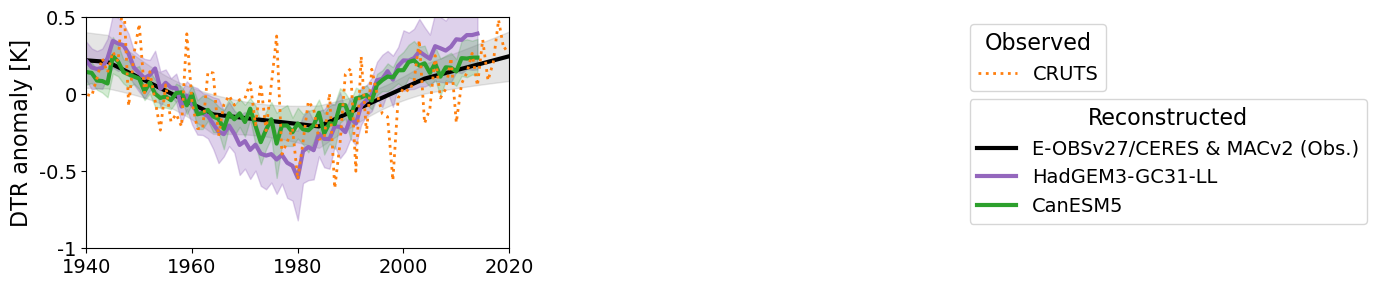

In [ ]:
fig = plt.figure(figsize=(12, 3), facecolor='white')
ax3 = fig.add_subplot(121)

dtrobs = dsobsdtr.AOD_Tmax.mean(['lon','lat']) - dsobsdtr.AOD_Tmin.mean(['lon','lat'])
dtrobsup = (dsobsdtr.AOD_Tmax - dsobsdtr.AOD_Tmin).mean(['lon','lat']) + (dsobsdtr.AOD_Tmax - dsobsdtr.AOD_Tmin).std(['lon','lat'])
dtrobsdown = (dsobsdtr.AOD_Tmax - dsobsdtr.AOD_Tmin).mean(['lon','lat']) - (dsobsdtr.AOD_Tmax - dsobsdtr.AOD_Tmin).std(['lon','lat'])

dtrhad = dshaddtr.AOD_Tmax.mean(['lon','lat']) - dshaddtr.AOD_Tmin.mean(['lon','lat'])
dtrhadup = (dshaddtr.AOD_Tmax - dshaddtr.AOD_Tmin).mean(['lon','lat']) + (dshaddtr.AOD_Tmax - dshaddtr.AOD_Tmin).std(['lon','lat'])
dtrhaddown = (dshaddtr.AOD_Tmax - dshaddtr.AOD_Tmin).mean(['lon','lat']) - (dshaddtr.AOD_Tmax - dshaddtr.AOD_Tmin).std(['lon','lat'])

dtrcan = dscandtr.AOD_Tmax.mean(['lon','lat']) - dscandtr.AOD_Tmin.mean(['lon','lat'])
dtrcanup = (dscandtr.AOD_Tmax - dscandtr.AOD_Tmin).mean(['lon','lat']) + (dscandtr.AOD_Tmax - dscandtr.AOD_Tmin).std(['lon','lat'])
dtrcandown = (dscandtr.AOD_Tmax - dscandtr.AOD_Tmin).mean(['lon','lat']) - (dscandtr.AOD_Tmax - dscandtr.AOD_Tmin).std(['lon','lat'])

ax3.plot(dtrobs.values, color = 'black', label = 'E-OBSv27/CERES & MACv2 (Obs.)', linestyle = '-', linewidth = 3, )
ax3.fill_between(np.linspace(0,170,171),dtrobsup.values,dtrobsdown.values, color = 'grey', alpha = 0.2)
ax3.plot(dtrhad.values, color = 'tab:purple', label = 'HadGEM3-GC31-LL', linestyle = '-', linewidth = 3, )
ax3.fill_between(np.linspace(0,164,165),dtrhadup.values, dtrhaddown.values, color = 'tab:purple', alpha = 0.3)
ax3.plot(dtrcan.values, color = 'tab:green', label = 'CanESM5', linestyle = '-', linewidth = 3, )
ax3.fill_between(np.linspace(0,164,165),dtrcanup.values, dtrcandown.values, color = 'tab:green', alpha = 0.2)

ax3.set_xticks([90,110,130,150,170])
ax3.set_xlim(90,170)
ax3.set_xticklabels([])
ax3.set_ylim(-1,0.5)
ax3.set_yticklabels([-1, -0.5, 0, 0.5], fontsize = 14)
ax3.set_ylabel('DTR anomaly [K]', fontsize = 16)
ax3.set_yticks([-1, -0.5, 0, 0.5])
ax3.set_xticklabels(['1940','1960','1980','2000','2020'], fontsize = 14)
# ax3.set_title('Reconstructed', fontsize = 16)
ax3.plot(np.concatenate([np.zeros(91),(d - np.mean(d[-80:]))[40:]]), color = 'tab:orange', label = 'CRUTS', linestyle = ':', linewidth = 2)
# ax3.set_title(r'a Estimated aerosol effects', loc = 'left', fontsize = 16)

h,l = ax3.get_legend_handles_labels()
fig.legend([h[3]],[l[3]], bbox_to_anchor = [0.983,0.89], fontsize = 14, title_fontsize = 16, title = 'Observed')
fig.legend([h[0],h[1],h[2]],[l[0],l[1],l[2]], bbox_to_anchor = [1.2,0.64], fontsize = 14, title_fontsize = 16, title = 'Reconstructed')

plt.savefig('...', dpi = 600, bbox_inches = 'tight')

In [ ]:
can = pd.DataFrame()

latlon = [[i.split('/')[-1].split('-')[0],i.split('/')[-1].split('-')[1][:-4]] if len(i.split('/')[-1].split('-')) == 2 else [i.split('/')[-1].split('-')[0],'-'+i.split('/')[-1].split('-')[-1][:-4]] for i in glob.glob('/data/causal-effects-CanESM5-01-14/*.npy')]

can = pd.DataFrame()
can['id'] = np.arange(len(latlon))

can['lat'] = np.nan
can['lon'] = np.nan

can.columns = can.columns.str.replace(' ', '')

for i in range(len(latlon)):
    k = np.where(can.id == i)[0][0]
    can.loc[k,'lat'] = latlon[i][0]
    can.loc[k,'lon'] = latlon[i][1]
        
    result = np.load('/data/causal-effects-CanESM5-01-14/'+str(latlon[i][0])+'-'+str(latlon[i][1])+'.npy', allow_pickle = True)
    
    cols = ['AOD-CC','AOD-SW','AOD-Tmin','CC-SW','CC-Tmax','CC-Tmin','SW-Tmax','Tmax-Tmin','Tmin-Tmax','AOD-CC-SW','AOD-Tmin-tot','AOD-Tmax-tot','AOD-SW-tot']
    lab = ['[]','[W/m2]','[K}','[W/m2]','[K]','[K]','[K/W/m2]','','','[W/m2]','[K]','[K]','[W/m2]']
    
    for n in range(13):     
        
        if (0 not in result[n][1:]) and all(~np.isnan(result[n][1:])) and np.unique(np.sign(result[n][1:])).shape[0] == 1:
            
            if n == 0:
                can.loc[k, cols[n]] = result[n][0]/100
            elif n in [3,4,5]:
                can.loc[k, cols[n]] = result[n][0]*100
            else:
                can.loc[k, cols[n]] = result[n][0]

In [ ]:
obs = pd.DataFrame()

latlon = [[i.split('/')[-1][:6],i.split('/')[-1][7:-4]] for i in glob.glob('/data/causal-effects-v27-01-14/*.npy')]

obs = pd.DataFrame()
obs['id'] = np.arange(len(latlon))

obs['lat'] = np.nan
obs['lon'] = np.nan

obs.columns = obs.columns.str.replace(' ', '')

for i in range(len(latlon)):
    k = np.where(obs.id == i)[0][0]
    obs.loc[k,'lat'] = latlon[i][0]
    obs.loc[k,'lon'] = latlon[i][1]
        
    result = np.load('/data/causal-effects-v27-01-14/'+str(latlon[i][0])+'-'+str(latlon[i][1])+'.npy', allow_pickle = True)
    
    cols = ['AOD-CC','AOD-SW','AOD-Tmin','CC-SW','CC-Tmax','CC-Tmin','SW-Tmax','Tmax-Tmin','Tmin-Tmax','AOD-CC-SW','AOD-Tmin-tot','AOD-Tmax-tot','AOD-SW-tot']
    lab = ['','[W/m2]','[K]','[W/m2]','[K]','[K]','[K/W/m2]','','','[W/m2]','[K]','[K]','[W/m2]']
    
    for n in range(13):     
        
        if (0 not in result[n][1:]) and all(~np.isnan(result[n][1:])) and np.unique(np.sign(result[n][1:])).shape[0] == 1:
            if n == 0:
                obs.loc[k, cols[n]] = result[n][0]/100
            elif n in [3,4,5]:
                obs.loc[k, cols[n]] = result[n][0]*100
            else:
                obs.loc[k, cols[n]] = result[n][0]

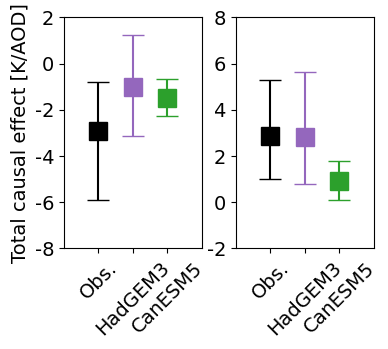

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2, figsize = (12/9*3,3), facecolor = 'white')

colors = ['black','tab:purple','tab:green']
legend = ['Obs','HadGEM3-GC31-LL','CanESM5']

ptx = [0,0,0,0,0,0,0,1,1,1,1,1,1,1]
pty = [0,1,2,3,4,5,6,0,1,2,3,4,5,6]
source = [0,1,2]
src = [obs, had, can]
columns = ['AOD-Tmax-tot','AOD-Tmin-tot']

steps = [[-8,-6,-4,-2,0,2],[-2,0,2,4,6,8]]
xlim = [[-8,2],[-2,8]]

for i in range(2):
    ax[i].errorbar(0, obs[columns[i]].mean(), [obs[columns[i]].mean()-obs[columns[i]].quantile([0.05]), obs[columns[i]].quantile([0.95])-obs[columns[i]].mean()],label = ['Obs'], 
                       color = 'black', marker = 's', markersize = 13, capsize = 8)
    ax[i].errorbar(1, had[columns[i]].mean(), [had[columns[i]].mean()-had[columns[i]].quantile([0.05]), had[columns[i]].quantile([0.95])-had[columns[i]].mean()],label = ['Obs'], 
                       color = 'tab:purple', marker = 's', markersize = 13, capsize = 8)
    ax[i].errorbar(2, can[columns[i]].mean(), [can[columns[i]].mean()-can[columns[i]].quantile([0.05]), can[columns[i]].quantile([0.95])-can[columns[i]].mean()],label = ['Obs'], 
                       color = 'tab:green', marker = 's', markersize = 13, capsize = 8)

    ax[i].set_xlim(-1,3)
    ax[i].set_xticks([])
    ax[i].set_xlabel('')
    ax[i].set_yticks(steps[i])
    ax[i].set_yticklabels(steps[i], fontsize = 14)
    ax[i].set_ylim(xlim[i])
    ax[i].set_xticks([0,1,2])
    ax[i].set_xticklabels(['Obs.','HadGEM3','CanESM5'], fontsize = 14, rotation = 45)
ax[0].set_ylabel('Total causal effect [K/AOD]', fontsize = 14)

# ax[i].legend([b["boxes"][0], b1["boxes"][0], b2["boxes"][0]], ['Obs','HadGEM3-GC31-LL','CanESM5'], bbox_to_anchor=(1.2, 1.05), ncol = 1, title = 'Data', 
#              fontsize = 14, title_fontsize = 14)

# plt.tight_layout()
plt.subplots_adjust(wspace=0.25)
plt.savefig('...', dpi = 600)

In [4]:
eobsv27 = read_in_AOD_SW('/data/causal-effects-v27-01-21/')

In [5]:
hadgem3 = read_in_AOD_SW('/data/causal-effects-HadGEM3-01-14/')

In [6]:
canesm5 = read_in_AOD_SW('/data/causal-effects-CanESM5-01-14/')

In [7]:
aodobs = xr.open_dataset('/data/MACv2-masked.nc').sel(time = slice('1850-12-31','2020-12-31'),lat = slice(35.12,69.89), lon = slice(-10.40,34.12))

In [8]:
aodhad = xr.open_dataset('/.../od550aer_day_HadGEM3-GC31-LL_r1_1850101-20141230-Europe.nc').sel(lat = slice(35.12,71.88), lon = slice(-10,35)).groupby('time.year').mean('time')
aodcan = xr.open_dataset('/.../od550aer_day_CanESM5_r1_18500101-20141231-Europe.nc').sel(lat = slice(35.12,71.16), lon = slice(-10, 35)).groupby('time.year').mean('time')

In [9]:
obsCE = eobsv27['AOD-SW'].mean()
obsCEplus = eobsv27['plus'].mean()
obsCEminus = eobsv27['minus'].mean()

hadCE = hadgem3['AOD-SW'].mean()
hadCEplus = hadgem3['plus'].mean()
hadCEminus = hadgem3['minus'].mean()

canCE = canesm5['AOD-SW'].mean()
canCEplus = canesm5['plus'].mean()
canCEminus = canesm5['minus'].mean()

In [10]:
aodO = np.nanmean(aodobs.aod_ann.values[-15:-5], axis = 0)[0] - aodobs.aod_ann.values[0]
aodHad = aodhad.od550aer.values[-1] - aodhad.od550aer.values[0]
aodCan = aodcan.od550aer.values[-1] - aodcan.od550aer.values[0]

In [11]:
anom = (aodobs.aod_ann.values[-15:-5] - aodobs.aod_ann.values[0])[:,0]
anomMean = np.nanmean(anom, axis = 0)
anomQ1 = np.nanquantile(anom, 0.05, axis = 0)
anomQ2 = np.nanquantile(anom, 0.95, axis = 0)

In [12]:
anomD1 = np.nanmean(anomMean - anomQ1)
anomD2 = np.nanmean(anomQ2 - anomMean)

In [13]:
import numpy as np
aodOmean = np.nanmean(anomMean)
aodOstd = [anomD1, anomD2]

aodHmean = np.nanmean(aodHad)

aodCmean = np.nanmean(aodCan)

In [15]:
erfobs = ERF(obsCE, aodOmean, obsCEplus, obsCEminus, aodOstd[1], aodOstd[0])
erfhad = ERF(hadCE, aodHmean, hadCEplus, hadCEminus, model = True)
erfcan = ERF(canCE, aodCmean, canCEplus, canCEminus, model = True)

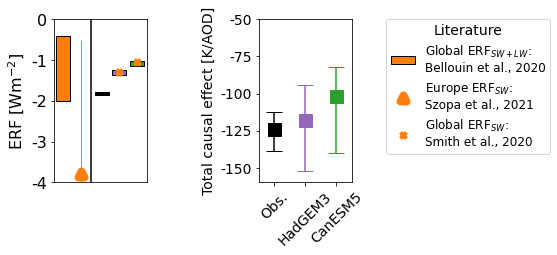

In [16]:
fig = plt.figure(figsize=(9, 3), facecolor='white')
   
ax2 = fig.add_subplot(131)

# ax2.bar(0, 6.7, 0.8, -7, hatch = '\\', color = 'tab:orange', edgecolor ='black', label = r'Europe ERF$_{SW}$:'+ '\n'+'Szopa et al., 2021')
ax2.bar(0, 2-0.4, 0.8, -2, color = 'tab:orange', edgecolor = 'black', label = r'Global ERF$_{SW+LW}$:'+ '\n'+ 'Bellouin et al., 2020')


ax2.vlines(1.6, 2, -4, color = 'black')
# ax2.hlines(0,-0.5,5.1,color = 'black', linestyle = ':')



ax2.bar(2.2, erfobs[2]+erfobs[1],0.8,  erfobs[0]-erfobs[2], color = 'black',
        edgecolor = 'black', label = 'E-OBSv27 & MACv2')
# ax2.hlines(np.nanmean(dsobs.AOD_SW.values[-15:-5].mean(axis = 0)),0.8,1.6,color = 'white', linestyle = '-', linewidth = 3)
ax2.bar(3.2, erfhad[1]+erfhad[2],0.8,  erfhad[0]-erfhad[2], color = 'tab:purple',
        edgecolor = 'black', label = 'HadGEM3-GC31-LL')
# ax2.hlines(np.nanmean(dshad.AOD_SW.values[-1]),1.8,2.6,color = 'white', linestyle = '-', linewidth = 3)
ax2.bar(4.2, erfcan[1]+erfcan[2],0.8,  erfcan[0]-erfcan[2], color = 'tab:green',
        edgecolor = 'black', label = 'CanESM5')
# ax2.hlines(np.nanmean(dscan.AOD_SW.values[-1]),2.8,3.6,color = 'white', linestyle = '-', linewidth = 3)

ax2.vlines(1, -7, -0.5, color = 'tab:orange', linewidth = 1)

ax2.scatter(1, -3.8, marker = '^', color = 'tab:orange', label = r'Europe ERF$_{SW}$:'+ '\n'+'Szopa et al., 2021', zorder = 10, linewidth = 8)
ax2.scatter(3.2, -1.3, marker = 'x', color = 'tab:orange', linewidth = 4, label = r'Global ERF$_{SW}$:'+ '\n'+'Smith et al., 2020', zorder = 10)
ax2.scatter(4.2, -1.04, marker = 'x', color = 'tab:orange', linewidth = 4, zorder = 10)

ax2.set_ylim(-4,0)
ax2.set_xlim(-0.5,4.8)

ax2.set_yticks([-4,-3,-2,-1,0])
ax2.set_yticklabels([-4,-3,-2,-1,0], fontsize = 16)
ax2.set_ylabel(r'ERF [Wm$^{-2}$]', fontsize = 16)

            
ax2.set_xticks([])
ax2.set_xticklabels([])

h,l = ax2.get_legend_handles_labels()
fig.legend([h[2],h[0],h[1]],[l[2],l[0],l[1]], bbox_to_anchor = [0.9,0.91], fontsize = 12, title_fontsize = 14, title = 'Literature')
# fig.legend([h[3],h[4],h[5]],[l[3],l[4],l[5]], bbox_to_anchor = [0.895,0.35], fontsize = 12, title_fontsize = 14, title = 'Reconstructed')

ax = fig.add_subplot(132)
ax.errorbar(0, obsCE, np.array([obsCEminus,obsCEplus]).reshape(2,1),label = ['Obs'], color = 'black', marker = 's', markersize = 13, capsize = 8)
ax.errorbar(1, hadCE, np.array([hadCEminus,hadCEplus]).reshape(2,1),label = ['Obs'], color = 'tab:purple', marker = 's', markersize = 13, capsize = 8)
ax.errorbar(2, canCE, np.array([canCEminus,canCEplus]).reshape((2,1)),label = ['Obs'], color = 'tab:green', marker = 's', markersize = 13, capsize = 8)
ax.set_xlim(-0.5,2.5)
ax.set_ylim(-160,-50)
ax.set_yticks([-150, -125, -100, -75, -50])
ax.set_yticklabels([-150, -125, -100, -75, -50], fontsize = 14)
# ax.set_ylabel(r'TCE [Wm$^{-2}$ AOD$^{-1}$]', fontsize = 16)
ax.set_ylabel('Total causal effect [K/AOD]', fontsize = 14)

ax.set_xticks([0,1,2])
ax.set_xticklabels(['Obs.','HadGEM3','CanESM5'],fontsize = 14, rotation = 45)

plt.subplots_adjust(wspace = 1.2)

plt.savefig('', dpi = 600, bbox_inches = 'tight')